### Data Uploading and Preprocessing

In [1]:
import os
import json
import pandas as pd

# ─── CONFIG ───────────────────────────────────────────────────────────
DATASET_ROOT = "/kaggle/input/is584dataset/dataset"
ASPECT_PATH  = os.path.join(DATASET_ROOT, "aspect_data", "review_with_aspect.jsonl")
CONFS        = [
    "ICLR_2017","ICLR_2018","ICLR_2019","ICLR_2020",
    "NIPS_2016","NIPS_2017","NIPS_2018","NIPS_2019"
]
# ────────────────────────────────────────────────────────────────────────

def extract_text_fields(doc):
    """Recursively collect all string values >50 chars from a nested JSON."""
    texts = []
    def recurse(o):
        if isinstance(o, str):
            if len(o.strip()) > 50:
                texts.append(o.strip())
        elif isinstance(o, list):
            for item in o:
                recurse(item)
        elif isinstance(o, dict):
            for v in o.values():
                recurse(v)
    recurse(doc)
    return "\n\n".join(texts) if texts else None

# 1) Load full paper texts
paper_records = []
for conf in CONFS:
    content_dir = os.path.join(DATASET_ROOT, conf, f"{conf}_content")
    if not os.path.isdir(content_dir):
        continue
    for fn in os.listdir(content_dir):
        if not fn.endswith("_content.json"):
            continue
        path = os.path.join(content_dir, fn)
        doc = json.load(open(path, "r"))
        sid = fn.replace("_content.json", "")
        text = extract_text_fields(doc)
        paper_records.append({"submission_id": sid, "paper_text": text})
paper_df = pd.DataFrame(paper_records)

# 2) Flatten aspect spans
asp_recs = []
with open(ASPECT_PATH, "r", encoding="utf-8") as f:
    for line in f:
        obj    = json.loads(line)
        sid    = obj["id"]
        revtxt = obj["text"]
        for st, ed, lbl in obj["labels"]:
            span = revtxt[st:ed].strip()
            if not span:
                continue
            asp_recs.append({
                "submission_id":   sid,
                "review_text":     revtxt,
                "aspect":          lbl,
                "aspect_sentence": span
            })
aspect_df = pd.DataFrame(asp_recs)

# 3) Merge papers + aspects, drop missing texts
df = aspect_df.merge(paper_df, on="submission_id", how="left")
df = df[df["paper_text"].notna()].reset_index(drop=True)

# 4) Filter to core aspects
core = ["clarity_positive","clarity_negative","soundness_positive","soundness_negative","motivation_positive","motivation_negative"]
df = df[df["aspect"].isin(core)]

# 5) Final fields
df = df[["paper_text","review_text","aspect","aspect_sentence"]]

# Quick sanity check
print("✔ df shape:", df.shape)
print(df["aspect"].value_counts().head())
print(df.head())

# ——— Sanitize text columns to remove/replace problematic chars ———
for col in ["paper_text", "review_text", "aspect_sentence"]:
    df[col] = df[col].apply(
        lambda x: x.encode("utf-8", "ignore").decode("utf-8") if isinstance(x, str) else x
    )

# Now save without error
df.to_csv("phase2_dataset.csv", index=False, encoding="utf-8")

✔ df shape: (71854, 4)
aspect
clarity_negative       15697
soundness_negative     15662
clarity_positive       13095
soundness_positive     12780
motivation_positive    11121
Name: count, dtype: int64
                                          paper_text  \
1  Deep neural networks (DNNs) have achieved impe...   
2  Deep neural networks (DNNs) have achieved impe...   
3  Deep neural networks (DNNs) have achieved impe...   
6  Deep neural networks (DNNs) have achieved impe...   
8  A long-term goal in artificial intelligence is...   

                                         review_text               aspect  \
1  This work studies the predictive uncertainty i...  motivation_positive   
2  This work studies the predictive uncertainty i...     clarity_positive   
3  This work studies the predictive uncertainty i...   soundness_negative   
6  This work studies the predictive uncertainty i...   soundness_negative   
8  Summary : This paper proposes a new approach t...  motivation_positive   


In [2]:
import os
import json
import pandas as pd

# ─── CONFIG ───────────────────────────────────────────────────────────
DATASET_ROOT = "/kaggle/input/is584dataset/dataset"
ASPECT_PATH  = os.path.join(DATASET_ROOT, "aspect_data", "review_with_aspect.jsonl")
CONFS        = [
    "ICLR_2017","ICLR_2018","ICLR_2019","ICLR_2020",
    "NIPS_2016","NIPS_2017","NIPS_2018","NIPS_2019"
]
CORE_ASPECTS = {
    "clarity_positive","clarity_negative",
    "soundness_positive","soundness_negative",
    "motivation_positive","motivation_negative"
}
# ────────────────────────────────────────────────────────────────────────

def extract_text_fields(doc):
    """Collect all string values ≥50 chars from nested JSON."""
    texts = []
    def recurse(o):
        if isinstance(o, str):
            if len(o.strip()) > 50:
                texts.append(o.strip())
        elif isinstance(o, dict):
            for v in o.values():
                recurse(v)
        elif isinstance(o, list):
            for item in o:
                recurse(item)
    recurse(doc)
    return "\n\n".join(texts) if texts else None

# 1) Load full paper texts
paper_records = []
for conf in CONFS:
    content_dir = os.path.join(DATASET_ROOT, conf, f"{conf}_content")
    if not os.path.isdir(content_dir):
        continue
    for fn in os.listdir(content_dir):
        if not fn.endswith("_content.json"):
            continue
        sid = fn.replace("_content.json", "")
        doc = json.load(open(os.path.join(content_dir, fn), "r"))
        text = extract_text_fields(doc)
        if text:
            paper_records.append({"submission_id": sid, "paper_text": text})
paper_df = pd.DataFrame(paper_records)
print(f"→ Loaded {len(paper_df)} papers")

# 2) Load aspect spans
asp_recs = []
with open(ASPECT_PATH, "r", encoding="utf-8") as f:
    for line in f:
        obj    = json.loads(line)
        sid    = obj["id"]
        revtxt = obj["text"]
        for st, ed, lbl in obj["labels"]:
            span = revtxt[st:ed].strip()
            if span:
                asp_recs.append({
                    "submission_id":   sid,
                    "review_text":     revtxt,
                    "aspect":          lbl,
                    "aspect_sentence": span
                })
aspect_df = pd.DataFrame(asp_recs)
print(f"→ Loaded {len(aspect_df)} aspect‐span entries")

# 3) Load all reviews, parse rating+confidence, pick top‐confidence one per paper
def parse_lead_int(s):
    """If s like '4: ...', return 4 else 0."""
    if not isinstance(s, str) or ":" not in s:
        return 0
    try:
        return int(s.split(":",1)[0])
    except:
        return 0

rev_recs = []
for conf in CONFS:
    rev_dir = os.path.join(DATASET_ROOT, conf, f"{conf}_review")
    if not os.path.isdir(rev_dir):
        continue
    for fn in os.listdir(rev_dir):
        if not fn.endswith("_review.json"):
            continue
        data = json.load(open(os.path.join(rev_dir, fn), "r"))
        root = data.get("root", data)
        sid  = root.get("id", fn.replace("_review.json",""))
        for rv in root.get("reviews", []):
            txt = rv.get("review","").strip()
            if not txt:
                continue
            rating     = parse_lead_int(rv.get("rating",""))
            confidence = parse_lead_int(rv.get("confidence",""))
            rev_recs.append({
                "submission_id": sid,
                "review":        txt,
                "rating":        rating,
                "confidence":    confidence
            })

rev_df = pd.DataFrame(rev_recs)
print(f"→ Loaded {len(rev_df)} raw review entries")

best_rev = (
    rev_df
    .sort_values(
        ["submission_id","confidence","rating"],
        ascending=[True, False, False]
    )
    .groupby("submission_id", as_index=False)
    .first()[["submission_id","review","confidence"]]
)
print(f"→ Selected {len(best_rev)} best‐confidence reviews")

# 4) Merge papers + aspects + chosen reviews
df = (
    aspect_df
    .merge(paper_df,  on="submission_id", how="left")
    .merge(best_rev,  on="submission_id", how="left")
    .dropna(subset=["paper_text","review_text"])
    .reset_index(drop=True)
)

# 5) Keep only core aspects
df = df[df["aspect"].isin(CORE_ASPECTS)]

# 6) Deduplicate per paper+aspect: pick the longest aspect_sentence
df["span_len"] = df["aspect_sentence"].str.len()
df = (
    df
    .sort_values(
        ["submission_id", "aspect", "span_len"],
        ascending=[True, True, False]
    )
    .drop_duplicates(["submission_id"], keep="first")
    .drop(columns="span_len")
)

# 7) Sanitize and save
for col in ["paper_text", "review", "aspect_sentence"]:
    df[col] = (df[col]
               .astype(str)
               .apply(lambda x: x.encode("utf-8","ignore")
                                .decode("utf-8")))
df.to_csv("phase2_dataset.csv", index=False, encoding="utf-8")
print(f"✔ Final dataset: {len(df)} rows")

→ Loaded 8850 papers
→ Loaded 148086 aspect‐span entries
→ Loaded 28122 raw review entries
→ Selected 8780 best‐confidence reviews
✔ Final dataset: 8704 rows


In [3]:
df.head(10)

,submission_id,review_text,aspect,aspect_sentence,paper_text,review,confidence
121061,ICLR_2017_1,This is a very interesting and fairly easy to ...,clarity_positive,"As a non-expert on this topic , it was easy to...",MAKING NEURAL PROGRAMMING ARCHITECTURES GENERA...,This paper improves significantly upon the ori...,5
31763,ICLR_2017_10,"* *Edit : Based on the discussion below , my m...",clarity_negative,There are also other typos throughout,Q-PROP: SAMPLE-EFFICIENT POLICY GRADIENT WITH ...,"**Edit: Based on the discussion below, my main...",5
135807,ICLR_2017_100,"In this paper , the authors use a separate int...",clarity_positive,The organization is generally very clear,INTROSPECTION:ACCELERATING NEURAL NETWORK TRAI...,EDIT: Updated score. See additional comment.\n...,5
122259,ICLR_2017_101,This was an interesting paper . The algorithm ...,clarity_positive,"The algorithm seems clear , the problem well-r...",The task of hyperparameter optimization is bec...,"This paper discusses Hyperband, an extension o...",5
419,ICLR_2017_102,The paper proposes a new memory access scheme ...,clarity_negative,The difference to the properties of normal NTM...,Recent work on neural Turing machines (NTMs) (...,*** Paper Summary ***\n\nThis paper formalizes...,4
59132,ICLR_2017_103,This paper points out that you can take an LST...,clarity_negative,"Unfortunately , this simple , effective and in...","Recurrent neural networks (RNNs), including ga...",This paper introduces a novel RNN architecture...,4
124269,ICLR_2017_104,The authors propose a recurrent neural network...,clarity_positive,In general the paper is well written and quite...,"In order to plan and act effectively, agent-ba...",[UPDATE]\nAfter going through the response fro...,5
66336,ICLR_2017_105,This paper explores ensemble optimisation in t...,clarity_positive,The paper is well written and accessible .,EPOPT: LEARNING ROBUST NEURAL NETWORK POLICIES...,This paper explores ensemble optimisation in t...,4
66731,ICLR_2017_106,In this paper a well known soft mixture of exp...,motivation_positive,This is clearly an interesting direction of fu...,Transferring knowledge from prior source tasks...,In this paper a well known soft mixture of exp...,4
77127,ICLR_2017_107,This paper proposes an approach to learning wo...,clarity_positive,The paper is clearly written,MULTI-VIEW RECURRENT NEURAL ACOUSTIC WORD EMBE...,This paper proposes an approach to learning wo...,4


In [4]:
df["aspect"].value_counts()

aspect
clarity_negative       6245
clarity_positive       1959
motivation_positive     219
motivation_negative     137
soundness_negative      111
soundness_positive       33
Name: count, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split

# ─── Load the prepared dataset ──────────────────────────────────────────
df = pd.read_csv("/kaggle/working/phase2_dataset.csv")

# Display overall class distribution
print("Overall aspect distribution:")
print(df["aspect"].value_counts(), "\n")

# ─── 1) Split off final test set (20% of data) ─────────────────────────
# We stratify by 'aspect' to keep class balance across splits.
train_val, test = train_test_split(
    df,
    test_size=0.20,
    stratify=df["aspect"],
    random_state=42
)

print(f"Train+Val shape: {train_val.shape}")
print(f"Test shape:        {test.shape}\n")

# ─── 2) Split train_val into train (80% of original) and val (10% of original) ─────────────────────────
# Since train_val is 80% of original, using test_size=0.125 yields 10% of original for validation.
train, val = train_test_split(
    train_val,
    test_size=0.125,
    stratify=train_val["aspect"],
    random_state=42
)

print(f"Train shape: {train.shape}")
print(f"Val shape:   {val.shape}")
print(f"Test shape:  {test.shape}\n")

# ─── 3) Verify class distribution in each split ─────────────────────────
print("Class distribution in TRAIN set:")
print(train["aspect"].value_counts(), "\n")

print("Class distribution in VAL set:")
print(val["aspect"].value_counts(), "\n")

print("Class distribution in TEST set:")
print(test["aspect"].value_counts(), "\n")

# ─── 4) Save splits to CSV for modeling ────────────────────────────────
train.to_csv("train.csv", index=False)
val.to_csv("val.csv",     index=False)
test.to_csv("test.csv",   index=False)

print("Saved train.csv, val.csv, test.csv")

Overall aspect distribution:
aspect
clarity_negative       6245
clarity_positive       1959
motivation_positive     219
motivation_negative     137
soundness_negative      111
soundness_positive       33
Name: count, dtype: int64 

Train+Val shape: (6963, 7)
Test shape:        (1741, 7)

Train shape: (6092, 7)
Val shape:   (871, 7)
Test shape:  (1741, 7)

Class distribution in TRAIN set:
aspect
clarity_negative       4371
clarity_positive       1371
motivation_positive     153
motivation_negative      96
soundness_negative       78
soundness_positive       23
Name: count, dtype: int64 

Class distribution in VAL set:
aspect
clarity_negative       625
clarity_positive       196
motivation_positive     22
motivation_negative     14
soundness_negative      11
soundness_positive       3
Name: count, dtype: int64 

Class distribution in TEST set:
aspect
clarity_negative       1249
clarity_positive        392
motivation_positive      44
motivation_negative      27
soundness_negative       22

### Baseline Model - Zero shot with longllama

In [8]:
# 1) Imports & Installs
# ─────────────────────────────────────────────────────────────────────
!pip install -q wandb evaluate transformers peft bitsandbytes rouge_score bert_score
import os, random, pandas as pd, numpy as np, wandb
import torch
import evaluate

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    GenerationConfig,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq,
    set_seed
)
from peft import LoraConfig, get_peft_model
from bitsandbytes import __version__ as bnb_version 

In [9]:
wandb.login(key="0e48c15605abf65402208cd05becaa061bf0dfbf")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: esrasekerci (esrasekerci-metu-middle-east-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [10]:
# ── 0) (Re)install required packages ──────────────────────────────────────
# !pip install wandb evaluate datasets transformers bitsandbytes peft

import os, shutil, torch, wandb, pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq,
)
from transformers.integrations import WandbCallback
from transformers import BitsAndBytesConfig
from peft import LoraConfig, get_peft_model

In [11]:
# ── 1) Sample and split ───────────────────────────────────────────────────
df = pd.read_csv("train.csv")
df = df[["aspect", "paper_text", "review"]]

sample = df.sample(500, random_state=42).reset_index(drop=True)

tval, test_df = train_test_split(sample, test_size=0.10,
                                 stratify=sample["aspect"],
                                 random_state=42)
train_df, val_df = train_test_split(tval, test_size=0.1111,
                                    stratify=tval["aspect"],
                                    random_state=42)
print("Splits:", train_df.shape, val_df.shape, test_df.shape)

hf_train = Dataset.from_pandas(train_df)
hf_val   = Dataset.from_pandas(val_df)

Splits: (400, 3) (50, 3) (50, 3)


In [14]:
train_df = (
    pd.read_csv("train.csv")
      .loc[:, ["aspect", "paper_text", "review"]]
)

val_df = (
    pd.read_csv("val.csv")
      .loc[:, ["aspect", "paper_text", "review"]]
)

test_df = (
    pd.read_csv("test.csv")
      .loc[:, ["aspect", "paper_text", "review"]]
)

print("Train / Val / Test shapes:", 
      train_df.shape, val_df.shape, test_df.shape)

hf_train = Dataset.from_pandas(train_df)
hf_val   = Dataset.from_pandas(val_df)
hf_test  = Dataset.from_pandas(test_df)

print("HF datasets:", 
      len(hf_train), len(hf_val), len(hf_test))

Train / Val / Test shapes: (6092, 3) (871, 3) (1741, 3)
HF datasets: 6092 871 1741


In [12]:
# ──────────────────────────────────────────────────────────────────────────────
# 3) Init Weights & Biases
# ──────────────────────────────────────────────────────────────────────────────
wandb.login()
wandb.init(
    project="is584-phase3",
    name="llama4bit_lora_sample",
    config={
        "model_id":    "syzymon/long_llama_3b_instruct",
        "sample_size": 500,
        "epochs":      1,
        "bsz":         1,
        "lr":          2e-5,
        "lora_r":      8,
    }
)

# ──────────────────────────────────────────────────────────────────────────────
# 4) Load Tokenizer & Base Model (4-bit quantized)
# ──────────────────────────────────────────────────────────────────────────────
MODEL_ID = wandb.config.model_id

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID, trust_remote_code=True
)
# repurpose EOS as PAD
tokenizer.pad_token    = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    device_map="auto",
    quantization_config=bnb_cfg,
    trust_remote_code=True
)

# ──────────────────────────────────────────────────────────────────────────────
# 5) Attach LoRA Adapters
# ──────────────────────────────────────────────────────────────────────────────
lora_cfg = LoraConfig(
    r=wandb.config.lora_r,
    lora_alpha=16,
    target_modules=["q_proj","v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(base_model, lora_cfg)
model.eval()

# ──────────────────────────────────────────────────────────────────────────────
# 6) Preprocess Function for Causal LM with Fixed-Length Padding
# ──────────────────────────────────────────────────────────────────────────────
max_input_len, max_target_len = 512, 128
max_total = max_input_len + max_target_len
pad_id = tokenizer.pad_token_id
label_pad = -100

def preprocess(batch):
    input_ids_list = []
    attention_mask_list = []
    label_ids_list = []

    for aspect, paper, review in zip(batch["aspect"], batch["paper_text"], batch["review"]):
        # 1) build prompt + paper
        prompt = f"Aspect: {aspect}\n\nPaper:\n{paper}"
        pr_ids = tokenizer(
            prompt,
            truncation=True,
            max_length=max_input_len,
            return_attention_mask=False
        )["input_ids"]

        # 2) tokenize review
        rv_ids = tokenizer(
            review,
            truncation=True,
            max_length=max_target_len,
            return_attention_mask=False
        )["input_ids"]

        # 3) concatenate
        input_ids = pr_ids + rv_ids
        labels    = [-100] * len(pr_ids) + rv_ids

        # 4) truncate if too long
        if len(input_ids) > max_total:
            input_ids = input_ids[-max_total:]
            labels    = labels[-max_total:]

        # 5) pad to fixed length
        pad_len = max_total - len(input_ids)
        input_ids = input_ids + [pad_id] * pad_len
        labels    = labels    + [label_pad] * pad_len
        attention_mask = [1] * (len(input_ids) - pad_len) + [0] * pad_len

        input_ids_list.append(input_ids)
        attention_mask_list.append(attention_mask)
        label_ids_list.append(labels)

    return {
        "input_ids": input_ids_list,
        "attention_mask": attention_mask_list,
        "labels": label_ids_list,
    }

# ──────────────────────────────────────────────────────────────────────────────
# 7) Tokenize Datasets
# ──────────────────────────────────────────────────────────────────────────────
hf_train_tok = hf_train.map(
    preprocess,
    batched=True,
    remove_columns=hf_train.column_names
)
hf_val_tok = hf_val.map(
    preprocess,
    batched=True,
    remove_columns=hf_val.column_names
)

# ──────────────────────────────────────────────────────────────────────────────
# 8) Define Metrics via evaluate
# ──────────────────────────────────────────────────────────────────────────────
bleu  = evaluate.load("bleu")
rouge = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    dec_preds  = tokenizer.batch_decode(preds, skip_special_tokens=True)
    dec_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    bleu_score = bleu.compute(
        predictions=[p.split() for p in dec_preds],
        references=[[l.split()] for l in dec_labels],
    )["bleu"]
    rouge_scores = rouge.compute(
        predictions=dec_preds,
        references=dec_labels,
        rouge_types=["rouge1","rouge2","rougeL"]
    )
    return {
        "bleu":  bleu_score,
        "rouge1": rouge_scores["rouge1"].mid.fmeasure,
        "rouge2": rouge_scores["rouge2"].mid.fmeasure,
        "rougeL": rouge_scores["rougeL"].mid.fmeasure,
    }

# ──────────────────────────────────────────────────────────────────────────────
# 9) TrainingArguments & Trainer Setup
# ──────────────────────────────────────────────────────────────────────────────
training_args = TrainingArguments(
    output_dir="sample_output",
    per_device_train_batch_size=wandb.config.bsz,
    per_device_eval_batch_size=wandb.config.bsz,
    gradient_accumulation_steps=4,
    learning_rate=wandb.config.lr,
    num_train_epochs=wandb.config.epochs,
    fp16=True,
    logging_steps=10,
    do_train=True,
    do_eval=True,
    eval_steps=100,
    save_steps=100,
    save_total_limit=2,
)

# watch gradients & parameters
wandb.watch(model, log="all")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_train_tok,
    eval_dataset=hf_val_tok,
    data_collator=None,           # already fixed-length padded
    compute_metrics=compute_metrics,
    callbacks=[WandbCallback],
)

tokenizer_config.json:   0%|          | 0.00/913 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/512k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggin

config.json: 0.00B [00:00, ?B/s]

configuration_longllama.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/syzymon/long_llama_3b_instruct:
- configuration_longllama.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_longllama.py: 0.00B [00:00, ?B/s]

longllama_utils.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/syzymon/long_llama_3b_instruct:
- longllama_utils.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/syzymon/long_llama_3b_instruct:
- modeling_longllama.py
- longllama_utils.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/6.85G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.85G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

You are adding a <class 'transformers.integrations.integration_utils.WandbCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
TensorBoardCallback
WandbCallback
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [13]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss
10,3.096800
20,2.916600
30,2.952900
40,2.966400
50,2.909500
60,2.835500
70,2.885000
80,2.936100
90,2.864000
100,2.847600


TrainOutput(global_step=100, training_loss=2.9210394477844237, metrics={'train_runtime': 594.2401, 'train_samples_per_second': 0.673, 'train_steps_per_second': 0.168, 'total_flos': 5109866496000000.0, 'train_loss': 2.9210394477844237, 'epoch': 1.0})

In [ ]:
trainer.save_model("full_output")
tokenizer.save_pretrained("full_output")
shutil.make_archive("full_output", "zip", "full_output")
print("Full-data LoRA fine-tuning complete. Download full_output.zip")

In [ ]:
trainer.save_model("sample_output")
tokenizer.save_pretrained("sample_output")
shutil.make_archive("sample_output", "zip", "sample_output")

In [14]:
from tqdm.auto import tqdm
import pandas as pd
import torch

teacher = model.eval()
device  = teacher.device
batch_size     = 16
max_src_len    = max_input_len
max_review_len = max_target_len

# Prebuild
prompts = [
    f"Aspect: {ex['aspect']}\n\nPaper:\n{ex['paper_text']}"
    for ex in hf_train
]
synthetic_reviews = []

# Generate in batches, but *only decode the new tokens*
for i in tqdm(range(0, len(prompts), batch_size),
              desc="Generating synthetic reviews"):
    batch_prompts = prompts[i : i + batch_size]
    enc = tokenizer(
        batch_prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_src_len
    ).to(device)

    with torch.inference_mode():
        out = teacher.generate(
            **enc,
            max_new_tokens=max_review_len,
            num_beams=1,
            do_sample=False,
            use_cache=True,
        )

    # slice off the prompt-length tokens and decode *only* the new ones
    prompt_len = enc["input_ids"].size(1)
    new_tokens = out[:, prompt_len:]                   # shape (bsz, <=max_review_len)
    dec_texts  = tokenizer.batch_decode(
        new_tokens, skip_special_tokens=True
    )
    synthetic_reviews += dec_texts

# Build your DataFrame
syn_df = pd.DataFrame({
    "paper_text": [ex["paper_text"] for ex in hf_train],
    "aspect":     [ex["aspect"]     for ex in hf_train],
    "review":     synthetic_reviews
})

print(syn_df.head())

Generating synthetic reviews:   0%|          | 0/25 [00:00<?, ?it/s]

                                          paper_text              aspect  \
0  Quick Shift is a popular mode-seeking and clus...  soundness_negative   
1  Modern industrial processes are often monitore...    clarity_negative   
2  We consider the standard K-armed adversarial b...    clarity_negative   
3  IMPROVING ROBUSTNESS WITHOUT SACRIFICING ACCUR...    clarity_positive   
4  Deep learning has achieved tremendous success ...    clarity_negative   

                                              review  
0  underlying density. This is a useful feature f...  
1  time series data. However, these methods are n...  
2  high probability, and the development of algor...  
3  a tendency to overfit to the training set (Zha...  
4  discovery, and we demonstrate their effectiven...  


In [15]:
syn_df.head()

,paper_text,aspect,review
0,Quick Shift is a popular mode-seeking and clus...,soundness_negative,underlying density. This is a useful feature f...
1,Modern industrial processes are often monitore...,clarity_negative,"time series data. However, these methods are n..."
2,We consider the standard K-armed adversarial b...,clarity_negative,"high probability, and the development of algor..."
3,IMPROVING ROBUSTNESS WITHOUT SACRIFICING ACCUR...,clarity_positive,a tendency to overfit to the training set (Zha...
4,Deep learning has achieved tremendous success ...,clarity_negative,"discovery, and we demonstrate their effectiven..."


In [16]:
import os
import shutil
import torch
import wandb
import evaluate

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    TrainingArguments,
    Trainer,
)
from transformers.integrations import WandbCallback

# ──────────────────────────────────────────────────────────────────────────────
# A)  Prepare student (T5) & tokenizer
# ──────────────────────────────────────────────────────────────────────────────
STUDENT_ID = "t5-small"
tokenizer  = AutoTokenizer.from_pretrained(STUDENT_ID)
student    = AutoModelForSeq2SeqLM.from_pretrained(STUDENT_ID).to(teacher.device)

# ──────────────────────────────────────────────────────────────────────────────
# B)  Build HF Dataset from synthetic DataFrame `syn_df`
# ──────────────────────────────────────────────────────────────────────────────
full_ds = Dataset.from_pandas(syn_df)
splits  = full_ds.train_test_split(test_size=0.1, seed=42)
train_ds, val_ds = splits["train"], splits["test"]

# ──────────────────────────────────────────────────────────────────────────────
# C)  Tokenization / Preprocessing (Seq2Seq style)
# ──────────────────────────────────────────────────────────────────────────────
max_in, max_out = 512, 128

def preprocess(batch):
    # build the same prompt your teacher saw
    inputs = tokenizer(
        [f"Aspect: {a}\n\nPaper:\n{p}" for a,p in zip(batch["aspect"], batch["paper_text"])],
        max_length=max_in,
        truncation=True,
        padding="max_length",
    )
    # tokenize the synthetic review as the decoder target
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            batch["review"],
            max_length=max_out,
            truncation=True,
            padding="max_length",
        )
    inputs["labels"] = labels["input_ids"]
    return inputs

train_tok = train_ds.map(
    preprocess, batched=True, remove_columns=train_ds.column_names
)
val_tok   = val_ds.map(
    preprocess, batched=True, remove_columns=val_ds.column_names
)

# ──────────────────────────────────────────────────────────────────────────────
# D)  Data collator & metrics
# ──────────────────────────────────────────────────────────────────────────────
data_collator = DataCollatorForSeq2Seq(tokenizer, model=student)

bleu  = evaluate.load("bleu")
rouge = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    decoded_preds  = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    bleu_score = bleu.compute(
        predictions=[p.split() for p in decoded_preds],
        references=[[l.split()] for l in decoded_labels],
    )["bleu"]
    rouge_scores = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        rouge_types=["rouge1","rouge2","rougeL"],
    )
    return {
        "bleu":   bleu_score,
        "rouge1": rouge_scores["rouge1"].mid.fmeasure,
        "rouge2": rouge_scores["rouge2"].mid.fmeasure,
        "rougeL": rouge_scores["rougeL"].mid.fmeasure,
    }

# ──────────────────────────────────────────────────────────────────────────────
# E)  TrainingArguments & Trainer (legacy flags)
# ──────────────────────────────────────────────────────────────────────────────
wandb.login()
wandb.init(
    project="is584-phase3",
    name="student_seq_distill"
)
wandb.watch(student, log="all")

training_args = TrainingArguments(
    output_dir="student_seq_output",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=5e-5,
    num_train_epochs=3,
    fp16=True,
    logging_steps=20,

    do_train=True,
    do_eval=True,
    eval_steps=200,
    save_steps=200,
    save_total_limit=2,
)

trainer = Trainer(
    model=student,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[WandbCallback],
)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇████
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇████
train/grad_norm,▂▂▅▅▁▁▆▆▇▇██▃▃▄▄▃▃██
train/learning_rate,██▇▇▆▆▆▆▅▅▄▄▃▃▃▃▂▂▁▁
train/loss,██▃▃▄▄▅▅▃▃▁▁▂▂▄▄▂▂▁▁
total_flos,5109866496000000.0
train/epoch,1
train/global_step,100
train/grad_norm,0.9281
train/learning_rate,0.0
train/loss,2.8476


/tmp/ipykernel_35/579006121.py:116: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
You are adding a <class 'transformers.integrations.integration_utils.WandbCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
TensorBoardCallback
WandbCallback


In [17]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
20,5.958200
40,3.752800
60,2.618100
80,2.428800
100,2.329500
120,2.311400


TrainOutput(global_step=135, training_loss=3.120204982051143, metrics={'train_runtime': 43.6901, 'train_samples_per_second': 24.72, 'train_steps_per_second': 3.09, 'total_flos': 146169145589760.0, 'train_loss': 3.120204982051143, 'epoch': 3.0})

In [ ]:
trainer.save_model("student_seq_output")
tokenizer.save_pretrained("student_seq_output")
shutil.make_archive("student_seq_output", "zip", "student_seq_output")

print("Student training complete. Download student_seq_output.zip")

In [31]:
import gc, torch
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

### Results

In [21]:
import warnings
import torch
from tqdm.auto import tqdm
import evaluate
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# ──────────────────────────────────────────────────────────────────────────────
# Silence only the big-buffer offload warning
warnings.filterwarnings(
    "ignore",
    ".*requires .* bytes of buffer for offloaded layers.*",
    module="accelerate.utils.modeling",
)

# ──────────────────────────────────────────────────────────────────────────────
# 1) Build prompt list and references (from your 500-sample test_df)
# ──────────────────────────────────────────────────────────────────────────────
test_df    = test_df.loc[:, ["aspect","paper_text","review"]]
prompts    = [
    f"Aspect: {r.aspect}\n\nPaper:\n{r.paper_text}"
    for r in test_df.itertuples()
]
references = test_df["review"].tolist()

# ──────────────────────────────────────────────────────────────────────────────
# 2) Load tokenizers
# ──────────────────────────────────────────────────────────────────────────────
BASE_ID    = "syzymon/long_llama_3b_instruct"
STUDENT_ID = "distilgpt2"

teacher_tok = AutoTokenizer.from_pretrained(BASE_ID, trust_remote_code=True)
teacher_tok.pad_token    = teacher_tok.eos_token
teacher_tok.pad_token_id = teacher_tok.eos_token_id

student_tok = AutoTokenizer.from_pretrained(STUDENT_ID)
student_tok.pad_token    = student_tok.eos_token
student_tok.pad_token_id = student_tok.eos_token_id

# ──────────────────────────────────────────────────────────────────────────────
# 3) Pre-tokenize once
# ──────────────────────────────────────────────────────────────────────────────
max_src = 512
enc_teacher = teacher_tok(
    prompts,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=max_src
)
enc_student = student_tok(
    prompts,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=max_src
)

# ──────────────────────────────────────────────────────────────────────────────
# 4) Load 4-bit quantized teacher on GPU
# ──────────────────────────────────────────────────────────────────────────────
device  = "cuda" if torch.cuda.is_available() else "cpu"
bnb_cfg = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)

teacher = AutoModelForCausalLM.from_pretrained(
    BASE_ID,
    device_map="auto",
    quantization_config=bnb_cfg,
    trust_remote_code=True,
).eval()

# ──────────────────────────────────────────────────────────────────────────────
# 5) Load student on GPU
# ──────────────────────────────────────────────────────────────────────────────
student = AutoModelForCausalLM.from_pretrained(STUDENT_ID).to(device).eval()

# ──────────────────────────────────────────────────────────────────────────────
# 6) Batched greedy generation
# ──────────────────────────────────────────────────────────────────────────────
def batch_generate_from_enc(model, enc, tokenizer, device, batch_size, max_new):
    outputs = []
    model.to(device)
    ids  = enc["input_ids"]
    mask = enc["attention_mask"]
    total = ids.size(0)
    for i in tqdm(range(0, total, batch_size),
                  desc=f"Generate {model.__class__.__name__}"):
        input_ids = ids[i:i+batch_size].to(device)
        attention_mask = mask[i:i+batch_size].to(device)
        with torch.inference_mode():
            gen = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=max_new,
                num_beams=1,
                do_sample=False,
                use_cache=True
            )
        pl = input_ids.shape[1]
        new = gen[:, pl:]
        outputs += tokenizer.batch_decode(new, skip_special_tokens=True)
    return outputs

zero_preds    = batch_generate_from_enc(
    teacher, enc_teacher, teacher_tok, device, batch_size=8,  max_new=128
)
student_preds = batch_generate_from_enc(
    student, enc_student, student_tok, device, batch_size=16, max_new=128
)

# ──────────────────────────────────────────────────────────────────────────────
# 7) Compute BLEU & ROUGE
# ──────────────────────────────────────────────────────────────────────────────
bleu  = evaluate.load("bleu")
rouge = evaluate.load("rouge")

def compute_scores(preds, refs):
    bleu_score = bleu.compute(
        predictions=preds,
        references=refs,
    )["bleu"]
    rouge_res = rouge.compute(
        predictions=preds,
        references=refs,
        rouge_types=["rouge1","rouge2","rougeL"]
    )
    return {
        "bleu":   bleu_score,
        "rouge1": rouge_res["rouge1"],
        "rouge2": rouge_res["rouge2"],
        "rougeL": rouge_res["rougeL"],
    }

zero_metrics    = compute_scores(zero_preds,    references)
student_metrics = compute_scores(student_preds, references)

# ──────────────────────────────────────────────────────────────────────────────
# 8) Display
# ──────────────────────────────────────────────────────────────────────────────
from pprint import PrettyPrinter
pp = PrettyPrinter()

print("\n➡️ Zero-Shot (Teacher):")
pp.pprint(zero_metrics)

print("\n➡️ Student Model:")
pp.pprint(student_metrics)

Generate LongLlamaForCausalLM:   0%|          | 0/7 [00:00<?, ?it/s]

Generate GPT2LMHeadModel:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



➡️ Zero-Shot (Teacher):
{'bleu': 0.00034334457539167055,
 'rouge1': 0.14279267959879144,
 'rouge2': 0.02728900814892339,
 'rougeL': 0.08551467717263828}

➡️ Student Model:
{'bleu': 0.0005954159152326647,
 'rouge1': 0.15621591359990364,
 'rouge2': 0.017033535435085158,
 'rougeL': 0.11100013395858016}


### Interpretability

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(



Top-10 tokens the model looked at to pick the next token:

  As           → 0.4823
  Ġcan         → 0.0147
  Ġrepresentation → 0.0089
  Ġas          → 0.0088
  Ġvector      → 0.0082
  Ġlearn       → 0.0081
  Ġfor         → 0.0077
  Ġhandle      → 0.0068
  Ġused        → 0.0066
  ding         → 0.0066


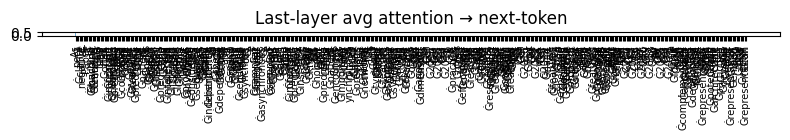

In [32]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
)
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ──────────────────────────────────────────────────────────────────────────────
# 1) Load your trained student (DistilGPT-2) with eager attention
# ──────────────────────────────────────────────────────────────────────────────
STUDENT_ID = "distilgpt2"  # or path/to/your/saved/student_output
tokenizer = AutoTokenizer.from_pretrained(STUDENT_ID)
tokenizer.pad_token    = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

# force eager-mode attention
model = AutoModelForCausalLM.from_pretrained(
    STUDENT_ID,
    output_attentions=True,
    attn_implementation="eager",
).to(DEVICE)
model.eval()

# ──────────────────────────────────────────────────────────────────────────────
# 2) Pick one example from your test split
# ──────────────────────────────────────────────────────────────────────────────
row = test_df.iloc[0]  # first test example
prompt = f"Aspect: {row.aspect}\n\nPaper:\n{row.paper_text}"

# ──────────────────────────────────────────────────────────────────────────────
# 3) Tokenize + forward with attentions
# ──────────────────────────────────────────────────────────────────────────────
enc = tokenizer(
    prompt,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=512
).to(DEVICE)

with torch.no_grad():
    outputs = model(
        **enc,
        output_attentions=True,
    )

# ──────────────────────────────────────────────────────────────────────────────
# 4) Extract last-layer attentions for the *new* token fill-in
# ──────────────────────────────────────────────────────────────────────────────
# attentions is tuple[layer] of shape (1, heads, seq_len, seq_len)
last_layer = outputs.attentions[-1][0]   # (heads, seq, seq)
# we’re predicting token at position `seq-1`, see which input positions it attended to:
attn_to_new = last_layer[:, -1, :]       # (heads, seq)
avg_attn    = attn_to_new.mean(dim=0)    # (seq,)

tokens = tokenizer.convert_ids_to_tokens(enc.input_ids[0])
scores = avg_attn.cpu().tolist()

# ──────────────────────────────────────────────────────────────────────────────
# 5) Print top-10 attended tokens
# ──────────────────────────────────────────────────────────────────────────────
topk = sorted(
    list(enumerate(scores)),
    key=lambda x: x[1],
    reverse=True
)[:10]

print("\nTop-10 tokens the model looked at to pick the next token:\n")
for idx, sc in topk:
    print(f"  {tokens[idx]:<12} → {sc:.4f}")

# ──────────────────────────────────────────────────────────────────────────────
# 6) Quick bar chart of all attentions
# ──────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(8,1.5))
plt.bar(range(len(tokens)), scores, alpha=0.6)
plt.xticks(range(len(tokens)), tokens, rotation=90, fontsize=7)
plt.title("Last-layer avg attention → next-token")
plt.tight_layout()
plt.show()

Top-10 tokens the model looked at to pick the next token:

As           → 0.4412
.            → 0.0624
graph        → 0.0586
networks     → 0.0392
Paper        → 0.0387
neural       → 0.0338
pect         → 0.0331
introduces   → 0.0322
clarity      → 0.0314
paper        → 0.0309


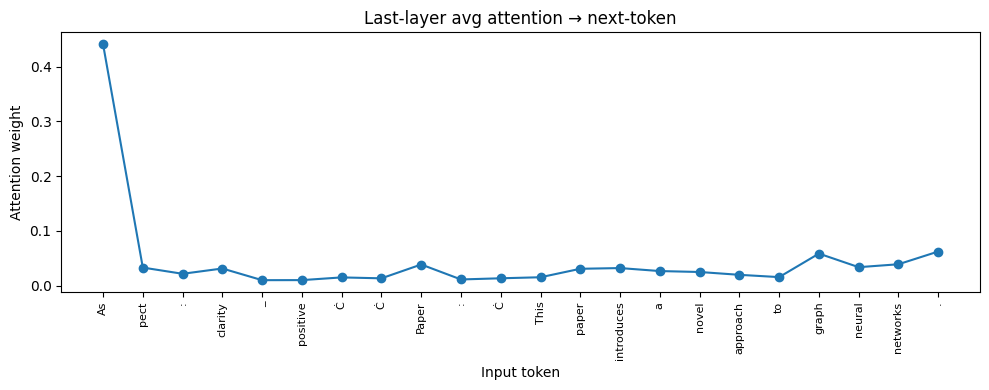

In [34]:
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

# 1) Setup
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
STUDENT_ID = "distilgpt2"

tokenizer = AutoTokenizer.from_pretrained(STUDENT_ID)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

# Enable output_attentions
model = AutoModelForCausalLM.from_pretrained(
    STUDENT_ID, output_attentions=True
).to(DEVICE).eval()

# 2) Encode a sample prompt (use your own test prompts here)
prompt = "Aspect: clarity_positive\n\nPaper:\nThis paper introduces a novel approach to graph neural networks."
enc = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to(DEVICE)

# 3) Forward pass with attentions
with torch.no_grad():
    outputs = model(**enc)

# 4) Extract last-layer attentions: shape = (batch, heads, seq_len, seq_len)
last_layer_attn = outputs.attentions[-1]                      # (1, H, L, L)
avg_across_heads = last_layer_attn.mean(dim=1)[0]             # (L, L)

# 5) Get weights the model used to predict next token (last row)
weights = avg_across_heads[-1].cpu().numpy()                  # (L,)

# 6) Map back to tokens
tokens = tokenizer.convert_ids_to_tokens(enc.input_ids[0])

# … after step 6 from the previous snippet …

# 7) Map back to *clean* tokens
raw_tokens = tokenizer.convert_ids_to_tokens(enc.input_ids[0])
tokens = [t.lstrip("Ġ") for t in raw_tokens]  # strip the Ġ

# 8) Show top-10 attended tokens (cleaned)
topk = weights.argsort()[-10:][::-1]
print("Top-10 tokens the model looked at to pick the next token:\n")
for idx in topk:
    print(f"{tokens[idx]:<12} → {weights[idx]:.4f}")

# 9) (optional) also display the cleaned tokens alongside positions
plt.figure(figsize=(10,4))
plt.plot(weights, marker="o")
plt.xticks(range(len(tokens)), tokens, rotation=90, fontsize=8)
plt.title("Last-layer avg attention → next-token")
plt.xlabel("Input token")
plt.ylabel("Attention weight")
plt.tight_layout()
plt.show()

In [36]:
import matplotlib.pyplot as plt
from IPython.display import FileLink

# 1. Save the figure to a file in your working directory
plt.gcf().set_size_inches(10, 4)
plt.tight_layout()
plt.savefig("attention_next_token.png", dpi=300)

<Figure size 1000x400 with 0 Axes>

In [40]:
from IPython.display import display, Markdown

# Number of examples to show
n_show = 5

# Randomly pick some indices (or just use range(n_show) for the first N)
import random
random.seed(42)
idxs = random.sample(range(len(prompts)), n_show)

for i, idx in enumerate(idxs, 1):
    prompt = prompts[idx]
    teach_out = zero_preds[idx]
    stud_out  = student_preds[idx]
    ref       = references[idx]
    
    display(Markdown(f"""---
### Example 
**Teacher (Zero-Shot) Generation**  
> {teach_out}

**Student (Distilled) Generation**  
> {stud_out}

**Human Reference**  
> {ref}

"""))

---
### Example 
**Teacher (Zero-Shot) Generation**  
> , 2016). The effective path approach can be used to understand the internal structure of a DNN model and identify the perturbation that can mislead the model. This approach can be used to improve the interpretability of DL models and prevent them from being vulnerable to input perturbations.

**Student (Distilled) Generation**  
>  effect of reducing the number of neurons in the neural network. The neural network is a network of neurons that are connected to the network and are connected to the network. The neural network is a network of neurons that are connected to the network and are connected to the network. The neural network is a network of neurons that are connected to the network and are connected to the network. The neural network is a network of neurons that are connected to the network and are connected to the network. The neural network is a network of neurons that are connected to the network and are connected to the network. The neural network is a network of neurons that are connected

**Human Reference**  
> This paper proposes a measure (“effective path”) of which units and weights were most important for classification of a particular input or input class. Using the effective path, the authors analyze the overlap between paths across classes for CNNs and between adversarially modified and unmodified images. Finally, the paper proposes an adversarial defense method based on effective path which detects adversarially manipulated images with high accuracy and generality to a variety of settings. 

Overall, this paper is interesting and provides several novel observations. The clarity of the exposition is generally good, but can be improved in several places (mentioned below). As for significance, effective path is likely to inform future analyses of neural networks, and the adversarial defense may prove impactful, though ultimately, its impact will depend on if and when the defense is broken. 

However, there are several important controls missing from the analysis, several claims which are unsubstantiated, and experimental details are lacking in a few places. As such, in its current form, I can only weakly recommend this paper for acceptance. If in the revision the controls requested below are included, additional evidence is provided for the unsubstantiated claims (or if those claims are toned down), and exposition of missing experimental details is included, I’d be happy to raise my score. 

Major points:

1) While the observation regarding path specialization is very interesting, one cannot gauge whether or not the degree of overlap observed between class-specific paths signals path specialization or simply high input-to-input path variance (which is similar both within and across classes). In order to distinguish between these possibilities, a measure of intra-class path similarity is necessary. In addition, an experiment similar to that in Figure 2 with CIFAR-10 would be quite helpful in evaluating whether this phenomenon exists in more natural datasets (the ImageNet results are difficult to interpret due to the large number of classes).

2) Several claims in the path specialization section are unsubstantiated. 

2a) In particular, the claim that ‘1’ has the highest degree of specialization “because of its unique shape” is made without evidence as is the similarity between ‘5’ and ‘8’. ‘6’ is also similar to ‘8’ and yet does not show the same similarity in the path specialization. These differences may very well simply be due to chance.

2b) The claim that the path specialization in ImageNet matches the class hierarchy is made only based on the rough non-linearity of Figure 3. Please either measure the overlap within and across class categories or soften this claim.

3) The similarity analysis for adversarial images is also very interesting, but a comparison between unmodified and randomly perturbed images with matched norms to the adversarially perturbed images is necessary to establish whether this effect is due to noise generally or adversarial noise.
It’s unclear how the effective path is calculated when negative weights are involved. Further exposition of this aspect would be helpful.

Minor points/typos: 

1) There are several places where confusing concepts are introduced in one paragraph but explained several paragraphs later. In particular, the distinction between synapses and weights is introduced halfway through page 2 but explained on page 3 and the fact that the coefficients for the defense metric are learned is unclear until page 4 even though they’re introduced on page 3.

2) Typos: 

2a) Section 1, fourth paragraph: “...and adversarial images, we uncover...” should be “...and adversarial images, and we uncover...”

2b) Section 1, fourth paragraph: “...by small perturbation, the network…” should be “...by small perturbations, the network…”

2c) Section 2, first paragraph: “...the black-boxed neural…” should be “...the black-box neural…”

2d) Section 2, first paragraph: “In the high level…” should be “At a high level…”

2e) Section 4, first paragraph: “...as it does no modify…” should be “...as it does not modify…”

2f) Title, should be "Neural Network"?



---
### Example 
**Teacher (Zero-Shot) Generation**  
> this approach.

The explanation model is a simplified representation of the original model, which can be used to understand the model's output. It is a more effective way to interpret the model's output compared to the original model, as it is easier to understand and provides a more accurate representation of the model's behavior.

The explanation model is a simplified representation of the original model, which can be used to understand the model's output. It is a more effective way to interpret the model's output compared to the original model, as it is easier to understand and provides a more accurate representation of the model'

**Student (Distilled) Generation**  
> MRI be used to measure the accuracy of a model’s output. We use the same method for the entire class of additive feature attribution methods (Section 6).
The first step is to define the class of additive feature attribution methods (Section 7).
The second step is to define the class of additive feature attribution methods (Section 8).
The third step is to define the class of additive feature attribution methods (Section 9).
The fourth step is to define the class of additive feature attribution methods (Section 10).
The fourth step is to define the class of additive feature attribution methods (Section 11).
The fifth step is

**Human Reference**  
> The authors show that several methods in the literature used for explaining individual model predictions fall into the category of "additive feature attribution" methods. They proposes a new kind of additive feature attribution method based on the concept of Shapely values and call the resulting explanations the SHAP values. The authors also suggest a new kernel called the shapely kernel which can be used to compute SHAP values via linear regression (a method they call kernel SHAP). They discuss how other methods, such as DeepLIFT, can be improved by better approximating the Shapely values.

Summary of review:
Positives:
(1) Novel and sound theoretical framework for approaching the question of model explanations, which has been very lacking in the field (most other methods were developed ad-hoc).
(2) Early versions of this paper have already been cited to justify improvements in other methods (specifically New DeepLIFT).
(3) Kernel SHAP is a significantly superior way of approximating Shapely values compared to classical Shapely sampling - much lower variance vs. number of model evaluations (Figure 3).
Negatives:
(1) Algorithm for Max SHAP is incorrect
(2) Proof for Kernel SHAP included in supplement is incomplete and hastily written
(3) Paper has significant typos: main text says runtime of Max SHAP is O(M^3) but supplement says O(M^2), equation for L under Theorem 2 has a missing close parenthesis for f()
(4) Argument that SHAP values are a superior form of model explanation is contentious. Case studies in Figure 4 have been chosen to favor SHAP. Paper doesn't have a discussion of the runtime for kernel SHAP or the recommended number of function evaluations needed for good performance. LIME was not included in the Figure 5 comparison.

Detailed comments:

The fact that Shapely values can be adapted to the task of model explanations is an excellent insight, and early versions of this paper have already been used by other authors to justify improvements to their methods (specifically New DeepLIFT). Kernel SHAP seems like a very significant contribution because, based on Figure 3, it has far lower variance compared to Shapely sampling when estimating the true Shapely values. It is also appealing because, unlike the popular method LIME, the choice of kernel here is motivated by a sound theoretical foundation.

However, there are a few problems with the paper. The algorithm for Max SHAP assumes that when i1 is greater than i2 and i2 is the largest input seen so far, then including i1 contributes (i1 - max(reference_of_i1, i2)) to the output. However, this is only true if none of the inputs which haven't been included yet have a reference value that exceeds max(reference_of_i1, i2). To give a concrete example, imagine there are two inputs, a and b, where a=10 and b=6, and the reference values are ref_a = 9 and ref_b = 0. The reference value of max(a,b) is 9, and the difference-from-reference is 10. The correct SHAP values are 1 for a and 0 for b, because b is so far below the reference of a that it never influences the output. However, the line phi[ind] += max(ref,0)/M will assign a SHAP value of 3 to b (ref = xsorted[i] - r[ind], which is 6-0 for b, and M=2). In the tests, it appears that the authors only checked cases where all inputs had the same reference. While this is often true of maxpooling neurons, it need not be true of maxout neurons. Also, the algorithm seems difficult to implement on a GPU in a way that would not significantly slow down backpropagation, particularly in the case of maxpooling layers. That said, this algorithm is not central to the thesis of the paper and was clearly written in a rush (the main text says the runtime is O(M^3) but the supplement says the runtime is O(M^2)).

Additionally, when I looked up the "Shapely kernel proof" in the supplement, the code provided for the computational proof was incomplete and the explanation was terse and contained grammatical errors. After several re-reads, my understanding of the proof is that:
(1) f_x(S) represents the output of the function when all inputs except those in the subset S are masked
(2) Shapely values are a linear function of the vector of values f_x(S) generated by enumerating all possible subsets S
(3) kernel SHAP (which is doing weighted linear regression) also produces an answer that is linear in the vector of all output values f_x(S)
(4) therefore, if the linear function in both cases is the same, then kernel SHAP is computing the Shapely values.
Based on this understanding, I expected the computational proof (which was performed for functions of up to 10 inputs) to check whether the final coefficients applied to the vector of output values when analytically solving kernel SHAP were the same as the coefficients used in the classic Shapely value computation. In other words, to use the standard formula for weighted linear regression, the final coefficients for kernel SHAP would be the matrix (X^T W X)^{-1} X^T W where X is a binary matrix in which the rows enumerate all possible subsets S and W are the weights computed by the shapely kernel; I expected the ith row of this matrix to match the coefficients for each S in the equation at the top of the page.
However, it appears that the code for the computational proof is not comparing any coefficients; rather, for a *specific* model generated by the method single_point_model, it compares the final Shapely values produced by kernel SHAP to the values produced by the classic Shapely value computation. Specifically, the code checks that there is negligible difference between kernel_vals and classic_vals, but classic_vals is returned by the method classic_shapely which accepts as one of its arguments a specific model f and returns the shapely values. The code also calls several methods for which the source has not been provided (namely single_point_model, rawShapely, and kernel_shapely).

The statement that SHAP values are a superior form of model explanation is contentious. The authors provide examples in Figure 4 where the SHAP values accord perfectly with human intuition for assigning feature importance, but it is also possible to devise examples where this might not be the case - for example, consider a filter in a convolutional neuron network which has a ReLU activation and a negative bias. This filter produces a positive output when it sees a sufficiently good match to some pattern and an output of zero otherwise. When the neuron produces an output of zero, a human might assign zero importance to all the pixels in the input because the input as a whole did not match the desired pattern. However, SHAP values may assign positive importance to those pixels which resemble the desire pattern and negative importance to the rest - in other words, it might assign nonzero importance to the input pixels even when the input is white noise.

In a similar vein, the argument to favor kernel SHAP over LIME would be more compelling if a comparison with LIME were included in Figure 5. The authors state that didn't do the comparison because the standard implementation of LIME uses superpixel segmentation which is not appropriate here. However, I understand that kernel SHAP and LIME are identical except for the choice of weighting kernel, so I am confused why the authors were not able to adapt their implementation of kernel SHAP to replicate LIME. Some discussion of runtime or the recommended number of function evaluations would have been desirable; the primary reason LIME uses superpixel segmentation for images is to reduce computational cost, and a key advantage of DeepLIFT-style backpropagation is computational efficiency.

The authors show a connection between DeepLIFT and the SHAP values which has already been used by the authors of DeepLIFT to justify improvements to their method. However, the section on Deep SHAP is problematic. The authors state that "Since the SHAP values for the simple components of the network can be analytically solved efficiently, this composition rule enables a fast approximation of values for the whole model", but they explicitly discuss only 2 analytical solutions: Linear SHAP and Max SHAP. Linear SHAP results in idential backpropagation rules for linear components as original DeepLIFT. As explained earlier, the algorithm for Max SHAP proposed in the supplement appears to be incorrect. The authors mention Low-order SHAP and state that it can be solved efficiently, but Low-order SHAP is not appropriate for many neural networks as individual neurons can have thousands of inputs, and even in the case where a neuron has very few inputs it is unclear if the weighted linear regression can be implemented on a GPU in a way that would not significantly slow down the backpropagation (the primary reason to use DeepLIFT-style backpropagation is computational efficiency).

Despite these problems, I feel that the adaptation of Shapely values to the task of model interpretation, as well as the development of kernel SHAP, are substantive enough to accept this paper.

REVISED REVIEW: The authors have addressed my concerns and corrected the issues.



---
### Example 
**Teacher (Zero-Shot) Generation**  
> algorithm's key components, discuss its convergence properties, and provide a detailed analysis of its performance.

2 THEORETICAL FRAMEWORK
We consider the minimax optimization problem in the form of a sequential game with two players, the leader and the follower. The leader commits to an action, and the follower responds after observing the leader's action. We focus on the zero-sum case of this problem, which is also known as minimax optimization.

3 THEORETICAL FRAMEWORK
We consider the minimax optimization problem in the form of a sequential game with two players, the leader

**Student (Distilled) Generation**  
>  the follower’s action.
The following code is made available at: https://github.com/gd-zhang/Follow-the-Ridge
leader whose gradient step takes the system away from the ridge. By adding a correction term to the follower, we explicitly cancel the follower’s action.
The following code is made available at: https://github.com/gd-zhang/Follow-the-Ridge
leader whose gradient step takes the system away from the ridge. By adding a correction term to the follower, we explicitly cancel the follower’s action.
The following code is

**Human Reference**  
> Summary: This paper designs a set of dynamics for learning in games called follow-the-ridge with the goal of finding local stackelberg equilibria. The main theoretical results show that the only stable attractors of the dynamics are stackelberg equilibria. Moreover, the authors give a deterministic convergence rate for the vanilla algorithm and a convergence rate using momentum. Empirical results show the learning dynamics cancel out rotational components and drive the vector field to zero rapidly, while reaching good performance on simple GAN examples.

Review: This paper focus on sequential games, which is the common formulation of GANs and a number of games in machine learning applications. From this perspective, it is natural to look at Stackelberg equilibria. In my opinion, the objective of the paper is important and relevant. The theoretical and empirical results are reasonably convincing. However, I do have some rather serious concerns about the general-sum game results and several questions regarding the relation to related work and the experiment details that need to be addressed.

1. The FR dynamics in algorithm 1 are closely related to the dynamics in [1]. In particular, the Jacobian of the FR dynamics is a similarity transform of the Jacobian of the dynamics in [1]. As a result, each algorithm has the same set of stable attractors. This should probably be mentioned in the paper. Given this relation, it is not clear what the advantage of the FR dynamics are over the dynamics in [1]. Could you please discuss this?

2. The gradient penalty regularization connection does not make sense in section 4.1. The optimization problem presented has an issue because the dimensions do not align in the constraint. The quantity \nabla_x f(x, y)^T H_yy^{-1}\nabla_x f(x, y) would not be defined if the dimensions of the players are not equal. 

3. In the related work it is claimed that two time-scale GDA converges only to local minimax and [2] is cited. I would avoid using this claim with respect to that paper since the statement following the main result in the paper is not right (see proposition 11 of [3] for proof). It is not clear what is meant when it is claimed that [1] can converge to non-local Stackelberg points. The dynamics in [1] only converge to local minimax points in the special case of zero-sum games.

4. Since the dynamics in the paper are the closest to those in [1], it seems that the paper would be stronger by comparing with that set of dynamics. 

5. I found it to be quite impressive that the vector field is driven to zero in the GAN examples. Just to clear, for each algorithm when the ‘gradient norm’ is shown, does this mean the norm of the update for each norm or does it mean the individual derivative for each player. For example in FR, would it be the norm of the derivative with respect to the follower variable of the function or the norm of the update including the second order information?

6. The path angle plot was interesting to see for the GAN example. The authors claim that the eigenvalues of the second order equilibria condition are non-negative. It would be nice if the authors could show the eigenvalues in the appendix and discuss how they were computed since it may be non-trivial to compute depending on the network size.

7. The damping method to stabilize training is not quite clear. Could you provide more details about how this was done?


My primary concerns have to do with the portion of the paper considering general-sum games. I do not understand where proposition 7 and 8 come from. I am not convinced the definitions provided are necessary and sufficient conditions for Stackelberg equilibria. In [1], a differential Stackelberg equilibrium is defined. The definition in this paper does not appear to agree with the definition in [1]. The final positive definite condition in proposition 7 and 8 does not appear to be taking the total derivative 2 times when I evaluate the derivatives, so I am not sure what the quantity is. If this is not a proper set of conditions for the equilibria, then it would also mean that the dynamics do not only converge to equilibria in general-sum games. It is important that the authors clear up this concern since I do not believe Theorem 3 holds as a consequence of problems with propositions 7 and 8.

[1] Fiez et al.,  "Convergence of Learning Dynamics in Stackelberg Games",  2019.
[2] Heusel et al., "GANs trained by a two time-scale update rule converge to a local Nash equilibrium", 2017.
[3] Mazumdar et al.,  "On Finding Local Nash Equilibria (and only Local Nash Equilibria) in Zero-Sum Games", 2019.

Post Author Response: Thanks to the authors for the effort in discussing the paper with me. The authors made several changes to the paper in response to my comments including removing section 4.1, fixing comments about related work, including details on the damping procedure, showing experimental comparisons to [1] along with an explanation of why the dynamics in this paper may be preferred for training GANs, providing details on propositions 7 and 8 and including reference to [1], adding further assumptions on the functions, and attempting to make theorem 3 more clear. Overall, I think this paper proposes an interesting set of dynamics, several meaningful theoretical guarantees, and impressive empirical results. I would be curious to see how it performs on even more large-scale GAN problems in the future. As a result, I have changed my original score from a weak reject to a weak accept. My primary concerns with the paper regarded the general-sum convergence results and I appreciated the explanations from the authors. I am still of the opinion that theorem 3 could be stated more rigorously in the sense that the neighborhood on which the local convergence holds should be more explicit. It seems to me that the convergence result may only hold in a ball around an equilibrium in which the implicit function is well-defined and the FR dynamics will be attracted to r(x) and that this space could be arbitrarily small for some problems. Nonetheless, this result is only in the appendix, and the paper includes enough contributions beyond this to warrant acceptance.



---
### Example 
**Teacher (Zero-Shot) Generation**  
> range dependencies.
SAN is a powerful method for capturing long-range dependencies, but it is not as widely used as RNN or CNN. It is mainly used for tasks like text classification (Zhang et al., 2017), text summarization (Zhang et al., 2017), and text generation (Zhang et al., 2017).

 The context dependency in NLP tasks is crucial for understanding the meaning of a sentence or text. The choice of network depends on the specific task and the network's merits and defects. Recurrent neural networks (RNN

**Student (Distilled) Generation**  
> Net (Kaswani et al., 2016).
The number of CNNs required to relate signals from two arbitrary input grows in the distance between positions, linearly for ConvS2S and logarithmically for ByteNet (Kaswani et al., 2016).
The number of CNNs required to relate signals from two arbitrary input grows in the distance between positions, linearly for ConvS2S and logarithmically for ByteNet (Kaswani et al., 2016).
The number of CNNs required to relate signals from two arbitrary input grows in the distance between positions, linearly

**Human Reference**  
> This high-quality paper tackles the quadratic dependency of memory on sequence length in attention-based models, and presents strong empirical results across multiple evaluation tasks. The approach is basically to apply self-attention at two levels, such that each level only has a small, fixed number of items, thereby limiting the memory requirement while having negligible impact on speed. It captures local information into so-called blocks using self-attention, and then applies a second level of self-attention over the blocks themselves.

The paper is well organized and clearly written, modulo minor language mistakes that should be easy to fix with further proof-reading. The contextualization of the method relative to CNNs/RNNs/Transformers is good, and the beneficial trade-offs between memory, runtime and accuracy are thoroughly investigated, and they're compelling.

I am curious how the story would look if one tried to push beyond two levels...? For example, how effective might a further inter-sentence attention level be for obtaining representations for long documents? 

Minor points:
- Text between Eq 4 & 5: W^{(1)} appears twice; one instance should probably be W^{(2)}.
- Multiple locations, e.g. S4.1: for NLI, the word is *premise*, not *promise*.
- Missing word in first sentence of S4.1: ... reason __ the ...



---
### Example 
**Teacher (Zero-Shot) Generation**  
> rely on dense matrices and require memory management.

In this paper, we propose a multiagent system that uses feedforward networks as its subset, and free from layer structure with matrix-vector scheme. We propose a variant of the multiagent system named "Sparse Connect SDAE" which is a variant of the standard SDAE model. We also propose a variant of the multiagent SDAE named "Sparse Connect SDAE" which is a variant of the standard SDAE model. We reimplemented Stacked Denoising Autoencoder(SDAE) as a concrete instance with our multi

**Student (Distilled) Generation**  
>  based on the same model as the neural network. We propose a multiagent system that has feedforward networks as its subset while free from layer structure with matrix-vector scheme. Deep networks are often compared to the brain neocortex or visual perception system. One of the largest difference from human brain is the use of matrix-vector multiplication based on layer architecture. It would help understanding the way human brain works if we manage to develop good deep network model without the layer architecture while preserving their performance. The brain neocortex works as an aggregation of the local level interactions between neurons, which is rather similar to multiagent system consists of autonomous partially observing agents

**Human Reference**  
> Unfortunately, the paper is not clear enough for me to understand what is being proposed. At a high-level the authors seem to propose a generalization of the standard layered neural architecture (of which MLPs are a special case), based on arbitrary nodes which communicate via messages. The paper then goes on to show that their layer-free architecture can perform the same computation as a standard MLP. This logic appears circular. The low level details of the method are also confusing: while the authors seem to be wanting to move away from layers based on matrix-vector products, Algorithm 4 nevertheless resorts to matrix-vector products for the forward and backwards pass. Although the implementation relies on asynchronously communicating nodes, the “locking” nature of the computation makes the two entirely equivalent.



In [41]:
df_examples = pd.DataFrame({
    "paper_text":  test_df["paper_text"],
    "reference":   references,
    "teacher_gen": zero_preds,
    "student_gen": student_preds,
})

# 2) Sample a few rows to inspect
sample_examples = df_examples.sample(5, random_state=42)
display(sample_examples)

# 3) Save to CSV and show a download link
csv_file = "generation_examples.csv"
sample_examples.to_csv(csv_file, index=False)
display(FileLink(csv_file))

,paper_text,reference,teacher_gen,student_gen
137,ACCUMULATION BIT-WIDTH SCALING FOR ULTRA- LOW ...,There has been a lot of work on limited precis...,") is quadratic with precision bit-width, which...","is, the FPU. The FPU is a single unit of the ..."
150,INITIALIZED EQUILIBRIUM PROPAGATION FOR BACKPR...,This is a nice improvement on Equilibrium Prop...,ibrating network and use the fast feedforward ...,\nThe following is a summary of the results:\n...
389,The most common way of representing material s...,This paper proposes a neural network architect...,"representation has been developed, which is mo...",2015) and the M-MCTS module are also used to ...
81,Deep learning training accesses vast amounts o...,This paper introduces Progressive Compressed R...,"al., 2019).\n\n The paper discusses the challe...","2016; Zhang et al., 2017).\nThe data pipeline..."
364,We propose a multiagent system that have feedf...,"Unfortunately, the paper is not clear enough f...",rely on dense matrices and require memory mana...,based on the same model as the neural network...


/kaggle/working/generation_examples.csv